<a href="https://colab.research.google.com/github/BifoldTide/-Core-SVM-Challenge-T-cnico/blob/main/(Core)_SVM_Challenge_T%C3%A9cnico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Carga de biblioecas y datos

In [1]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Bibliotecas de modelos
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

In [2]:
# Datos
path_train = "/content/drive/MyDrive/BBDD SONDA/Titanic-train.csv"
path_test = "/content/drive/MyDrive/BBDD SONDA/Titanic-test.csv"

dftr = pd.read_csv(path_train)
dfte = pd.read_csv(path_test)

dftr["uso"] = "training"
dfte["uso"] = "test"
df = pd.concat([dftr, dfte])
dfte.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
 11  uso          418 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 39.3+ KB


In [3]:
df["Name"].head(20)

,Name
0,"Braund, Mr. Owen Harris"
1,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,"Heikkinen, Miss. Laina"
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,"Allen, Mr. William Henry"
5,"Moran, Mr. James"
6,"McCarthy, Mr. Timothy J"
7,"Palsson, Master. Gosta Leonard"
8,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)"
9,"Nasser, Mrs. Nicholas (Adele Achem)"


### Limpieza

In [4]:
# Drop the column with most nulls
df.drop(columns = "Cabin", inplace = True)

In [5]:
# Clean the outliers and anomalies
df["Pclass"].value_counts()
df.loc[df["Pclass"] == 30, "Pclass"] = 3

In [6]:
df["Survived"].value_counts()
df.loc[df["Survived"] == 30, "Survived"] = 0

In [7]:
df["Embarked"].value_counts()
df.groupby("Embarked")["Survived"].value_counts()
df.loc[df["Embarked"].isna(), "Embarked"] = "S"

In [8]:
df.loc[df["Fare"].isna(), "Fare"] = df["Fare"].mean()

In [9]:
df.groupby("Survived")["Age"].agg(["mean", "max", "min"])

,mean,max,min
Survived,,,
0.0,30.626179,74.0,1.00
1.0,28.343690,80.0,0.42


In [10]:
df.loc[df["Age"].isna(), "Age"] = round(df["Age"].mean())

In [11]:
df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,uso
413,1305,NaN,3,"Spector, Mr. Woolf",male,30.0,0,0,A.5. 3236,8.0500,S,test
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C,test
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S,test
416,1308,NaN,3,"Ware, Mr. Frederick",male,30.0,0,0,359309,8.0500,S,test
417,1309,NaN,3,"Peter, Master. Michael J",male,30.0,1,1,2668,22.3583,C,test


In [12]:
# Separar los dataset
dfte = df[df["Survived"].isna()]
dftr = df[~df["Survived"].isna()]

# Eliminar columna de más
dftr = dftr.drop(columns = "uso")
dfte = dfte.drop(columns = "uso")

### Gráficos

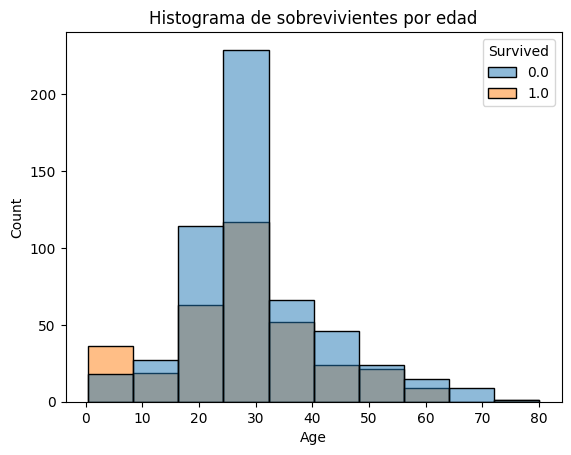

In [14]:
# Histograma de edad por supervivencia
sns.histplot(data = dftr, x = "Age", bins = 10, hue = "Survived")
plt.title("Histograma de sobrevivientes por edad")
plt.show()

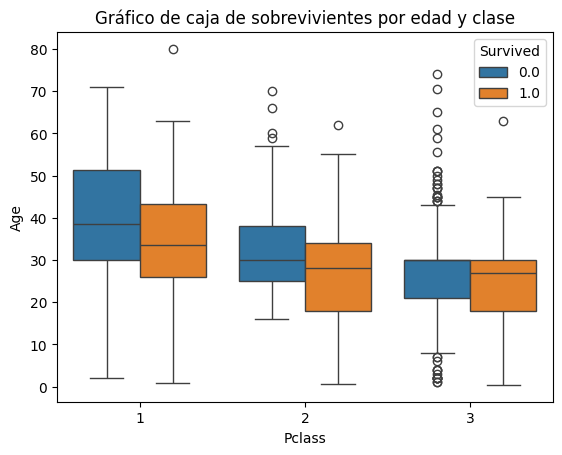

In [15]:
# Gráfico de cajas de sobrevivientes por edad y clase
sns.boxplot(data = dftr, x = "Pclass", y = "Age", hue = "Survived")
plt.title("Gráfico de caja de sobrevivientes por edad y clase")
plt.show()

### Entrenamiento

In [16]:
# Organización de parámetros
X = dftr.drop(columns = "Survived")
y = dftr["Survived"]

# Orden de columnas
col_num = ["PassengerId", "Pclass", "Age", "SibSp", "Parch", "Fare"]
col_nom = ["Name","Sex", "Ticket", "Embarked"]

In [17]:
# Transformar datos
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), col_num),
    ("nom", OneHotEncoder(handle_unknown='ignore'), col_nom)
])

In [19]:
# Crear pipelines de modelo

# Logístico
pipeline_log = Pipeline(steps=[
    ("pp", preprocessor),
    ("model", LogisticRegression(random_state = 96))])

# Árbol
pipeline_tree = Pipeline(steps=[
    ("pp", preprocessor),
    ("model", DecisionTreeClassifier(random_state = 96))])

# KNN
pipeline_neighbor = Pipeline(steps=[
    ("pp", preprocessor),
    ("model", KNeighborsClassifier(n_neighbors=5))])

# XGBoost
pipeline_xgb = Pipeline(steps=[
    ("pp", preprocessor),
    ("model", XGBClassifier(n_estimators = 100, random_state = 96))])

# LGBM
pipeline_lgbm = Pipeline(steps=[
    ("pp", preprocessor),
    ("model", LGBMClassifier(n_estimators = 100, random_state = 96))])

In [20]:
# Entrenamiento y predicciones
pipeline_log.fit(X, y)
pipeline_tree.fit(X, y)
pipeline_neighbor.fit(X, y)
pipeline_xgb.fit(X, y)
pipeline_lgbm.fit(X, y)

y_pred_log = pipeline_log.predict(dfte)
y_pred_tree = pipeline_tree.predict(dfte)
y_pred_neigh = pipeline_neighbor.predict(dfte)
y_pred_xgb = pipeline_xgb.predict(dfte)
y_pred_lgbm = pipeline_lgbm.predict(dfte)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 484
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [21]:
# Validación cruzada

# Accuracy
acc_log = cross_val_score(pipeline_log, X, y, cv=3, scoring="accuracy", n_jobs=-1)
acc_knn = cross_val_score(pipeline_neighbor, X, y, cv=3, scoring="accuracy", n_jobs=-1)
acc_tree = cross_val_score(pipeline_tree, X, y, cv=3, scoring="accuracy", n_jobs=-1)
acc_xgb = cross_val_score(pipeline_xgb, X, y, cv=3, scoring="accuracy", n_jobs=-1)
acc_lgbm = cross_val_score(pipeline_lgbm, X, y, cv=3, scoring="accuracy", n_jobs=-1)

print(f"Accuracy de Logistic: {acc_log}")
print(f"Accuracy de KNN: {acc_knn}")
print(f"Accuracy de Árbol: {acc_tree}")
print(f"Accuracy de XGBoost: {acc_xgb}")
print(f"Accuracy de LightGBM: {acc_lgbm}")

# Precision
pres_log = cross_val_score(pipeline_log, X, y, cv=3, scoring="precision", n_jobs=-1)
pres_knn = cross_val_score(pipeline_neighbor, X, y, cv=3, scoring="precision", n_jobs=-1)
pres_tree = cross_val_score(pipeline_tree, X, y, cv=3, scoring="precision", n_jobs=-1)
pres_xgb = cross_val_score(pipeline_xgb, X, y, cv=3, scoring="precision", n_jobs=-1)
pres_lgbm = cross_val_score(pipeline_lgbm, X, y, cv=3, scoring="precision", n_jobs=-1)

print("\n")
print(f"Precisión de Logistic: {pres_log}")
print(f"Precisión de KNN: {pres_knn}")
print(f"Precisión de Árbol: {pres_tree}")
print(f"Precisión de XGBoost: {pres_xgb}")
print(f"Precisión de LightGBM: {pres_lgbm}")

Accuracy de Logistic: [0.79124579 0.7979798  0.81144781]
Accuracy de KNN: [0.7979798  0.79124579 0.77777778]
Accuracy de Árbol: [0.79461279 0.8047138  0.83501684]
Accuracy de XGBoost: [0.74410774 0.5016835  0.81144781]
Accuracy de LightGBM: [0.73400673 0.55555556 0.83838384]


Precisión de Logistic: [0.76530612 0.74107143 0.80208333]
Precisión de KNN: [0.78723404 0.70634921 0.78571429]
Precisión de Árbol: [0.81927711 0.72222222 0.88235294]
Precisión de XGBoost: [0.78787879 0.43307087 0.88157895]
Precisión de LightGBM: [0.87234043 0.4612069  0.93421053]


###Optimizador

In [22]:
# Definir el espacio de hiperparámetros

param_grid_log = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l2'],
    'model__solver': ['liblinear', 'lbfgs']
}

param_grid_knn = {
    'model__n_neighbors': [3, 5, 7, 9, 11, 15],
    'model__weights': ['uniform', 'distance'],
    'model__p': [1, 2]
}

param_grid_tree = {
    'model__max_depth': [None, 5, 10, 15, 20],
    'model__min_samples_split': [2, 5, 10, 20],
    'model__min_samples_leaf': [1, 2, 4, 8],
    'model__max_features': [None, 'sqrt', 'log2']
}

param_grid_xgb = {
    'model__n_estimators': [50, 100, 150],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 5, 7],
    'model__subsample': [0.7, 0.8, 0.9],
    'model__colsample_bytree': [0.7, 0.8, 0.9],
    'model__gamma': [0, 0.1, 0.2],
    'model__reg_alpha': [0, 0.1, 0.5]
}

param_grid_lgbm = {
    'model__n_estimators': [50, 100, 150],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__num_leaves': [20, 31, 50],
    'model__max_depth': [5, 7, 10],
    'model__subsample': [0.7, 0.8, 0.9],
    'model__colsample_bytree': [0.7, 0.8, 0.9],
    'model__reg_alpha': [0, 0.1, 0.5],
    'model__reg_lambda': [0, 0.1, 0.5]
}


In [23]:
# Configurar GridSearchCV
grid_search_log = GridSearchCV(
    estimator=pipeline_log,
    param_grid=param_grid_log,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search_knn = GridSearchCV(
    estimator=pipeline_neighbor,
    param_grid=param_grid_knn,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search_tree = GridSearchCV(
    estimator=pipeline_tree,
    param_grid=param_grid_tree,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search_xgb = GridSearchCV(
    estimator=pipeline_xgb,
    param_grid=param_grid_xgb,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search_lgbm = GridSearchCV(
    estimator=pipeline_lgbm,
    param_grid=param_grid_lgbm,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

In [24]:
# Ejecutar GridSearchCV
grid_search_log.fit(X, y)
grid_search_knn.fit(X, y)
grid_search_tree.fit(X, y)
grid_search_xgb.fit(X, y)
grid_search_lgbm.fit(X, y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
Fitting 5 folds for each of 6561 candidates, totalling 32805 fits
[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 484
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pp',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['PassengerId',
                                                                          'Pclass',
                                                                          'Age',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'Fare']),
                                                                        ('nom',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Name',
                                                                          'Sex',
                                                                          'Ticket',
                                                                          'Embarked'])])),
                                       ('model',
                                        LGBMClassifier(random_state=96))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.7, 0.8, 0.9],
                         'model__learning_rate': [0.01, 0.05, 0.1],
                         'model__max_depth': [5, 7, 10],
                         'model__n_estimators': [50, 100, 150],
                         'model__num_leaves': [20, 31, 50],
                         'model__reg_alpha': [0, 0.1, 0.5],
                         'model__reg_lambda': [0, 0.1, 0.5],
                         'model__subsample': [0.7, 0.8, 0.9]},
             scoring='accuracy', verbose=1)

In [32]:
# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros encontrados según modelo:")
print("Regresión linear no lo necesita")
print(f" Clasificación Logística: {grid_search_log.best_params_}")
print(f" Clasificación KNN: {grid_search_knn.best_params_}")
print(f" Clasificación de árbol: {grid_search_tree.best_params_}")
print(f" Clasificación XGBoost: {grid_search_xgb.best_params_}")
print(f" Clasificación LGBM: {grid_search_lgbm.best_params_}")

# Evaluar el mejor modelo en el conjunto de prueba
best_model_log = grid_search_log.best_estimator_
best_model_knn = grid_search_knn.best_estimator_
best_model_tree = grid_search_tree.best_estimator_
best_model_xgb = grid_search_xgb.best_estimator_
best_model_lgbm = grid_search_lgbm.best_estimator_

# Accuracy
acc_log = cross_val_score(best_model_log, X, y, cv=3, scoring="accuracy", n_jobs=-1)
acc_knn = cross_val_score(best_model_knn, X, y, cv=3, scoring="accuracy", n_jobs=-1)
acc_tree = cross_val_score(best_model_tree, X, y, cv=3, scoring="accuracy", n_jobs=-1)
acc_xgb = cross_val_score(best_model_xgb, X, y, cv=3, scoring="accuracy", n_jobs=-1)
acc_lgbm = cross_val_score(best_model_lgbm, X, y, cv=3, scoring="accuracy", n_jobs=-1)

# Precision

pres_log = cross_val_score(best_model_log, X, y, cv=3, scoring="precision", n_jobs=-1)
pres_knn = cross_val_score(best_model_knn, X, y, cv=3, scoring="precision", n_jobs=-1)
pres_tree = cross_val_score(best_model_tree, X, y, cv=3, scoring="precision", n_jobs=-1)
pres_xgb = cross_val_score(best_model_xgb, X, y, cv=3, scoring="precision", n_jobs=-1)
pres_lgbm = cross_val_score(best_model_lgbm, X, y, cv=3, scoring="precision", n_jobs=-1)

# Recall

rec_log = cross_val_score(best_model_log, X, y, cv=3, scoring="recall", n_jobs=-1)
rec_knn = cross_val_score(best_model_knn, X, y, cv=3, scoring="recall", n_jobs=-1)
rec_tree = cross_val_score(best_model_tree, X, y, cv=3, scoring="recall", n_jobs=-1)
rec_xgb = cross_val_score(best_model_xgb, X, y, cv=3, scoring="recall", n_jobs=-1)
rec_lgbm = cross_val_score(best_model_lgbm, X, y, cv=3, scoring="recall", n_jobs=-1)

# F1

F1_log = cross_val_score(best_model_log, X, y, cv=3, scoring="f1", n_jobs=-1)
F1_knn = cross_val_score(best_model_knn, X, y, cv=3, scoring="f1", n_jobs=-1)
F1_tree = cross_val_score(best_model_tree, X, y, cv=3, scoring="f1", n_jobs=-1)
F1_xgb = cross_val_score(best_model_xgb, X, y, cv=3, scoring="f1", n_jobs=-1)
F1_lgbm = cross_val_score(best_model_lgbm, X, y, cv=3, scoring="f1", n_jobs=-1)

print("\n")
print(f"Parámetros mejorados de Logistic. Accuracy: {acc_log}, Precisión: {pres_log}, Recall: {rec_log}, F1: {F1_log}")
print(f"Parámetros mejorados de KNN. Accuracy: {acc_knn}, Precisión: {pres_knn}, Recall: {rec_knn}, F1: {F1_knn}")
print(f"Parámetros mejorados de Árbol. Accuracy: {acc_tree}, Precisión: {pres_tree}, Recall: {rec_tree}, F1: {F1_tree}")
print(f"Parámetros mejorados de XGBoost. Accuracy: {acc_xgb}, Precisión: {pres_xgb}, Recall: {rec_xgb}, F1: {F1_xgb}")
print(f"Parámetros mejorados de LightGBM. Accuracy: {acc_lgbm}, Precisión: {pres_lgbm}, Recall: {rec_lgbm}, F1: {F1_lgbm}")

Mejores hiperparámetros encontrados según modelo:
Regresión linear no lo necesita
 Clasificación Logística: {'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
 Clasificación KNN: {'model__n_neighbors': 5, 'model__p': 1, 'model__weights': 'distance'}
 Clasificación de árbol: {'model__max_depth': 5, 'model__max_features': None, 'model__min_samples_leaf': 8, 'model__min_samples_split': 2}
 Clasificación XGBoost: {'model__colsample_bytree': 0.7, 'model__gamma': 0.2, 'model__learning_rate': 0.05, 'model__max_depth': 7, 'model__n_estimators': 50, 'model__reg_alpha': 0.1, 'model__subsample': 0.7}
 Clasificación LGBM: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 7, 'model__n_estimators': 50, 'model__num_leaves': 31, 'model__reg_alpha': 0, 'model__reg_lambda': 0.5, 'model__subsample': 0.7}


Parámetros mejorados de Logistic. Accuracy: [0.8013468  0.81818182 0.81481481], Precisión: [0.77227723 0.75862069 0.8172043 ], Recall: [0.68421053 

In [29]:
# Predicciones según el mejor modelo
log_pred = best_model_log.predict(dfte)
knn_pred = best_model_knn.predict(dfte)
tree_pred = best_model_tree.predict(dfte)
xgb_pred = best_model_xgb.predict(dfte)
lgbm_pred = best_model_lgbm.predict(dfte)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [40]:
# Exportar las predicciones del mejor modelo
id_column = dfte['PassengerId']
df_pred = pd.DataFrame({
    'PassengerId': id_column,
    'Survived': log_pred
})
df_pred
df_pred.to_csv("Survival Prediction.csv")

### Conclusiones:
- Con los modelos sin optimizar, el mejor para este caso sería el de KNN por su alta certeza (%0.7979), aunque el de XGBoost también muestra una mejora en la precisión.
- Utilizando GRidSearch CV, los mejores modelos son Regresión Logística y KNN debido a su certeza y estabilidad de parámetros de predicción.
Hubiera sido XGBoost, pero es muy inestable en la partición de datos.